Outlier removal: kept 1694/1694 points.
Applied Savitzky-Golay smoothing (window=11, poly=2).

=== DCA FIT METRICS (in-sample) ===
EXP params: [1.05981751e+02 1.45154614e-02]
  RMSE: 11.6956 | MAE: 8.5608 | R2: 0.6744
----------------------------------------
HYPERBOLIC params: [1.15569427e+02 2.81846773e-02 1.41923169e+00]
  RMSE: 11.2561 | MAE: 8.0174 | R2: 0.6985
----------------------------------------
HARMONIC params: [1.12839151e+02 2.30101444e-02]
  RMSE: 11.2989 | MAE: 8.0764 | R2: 0.6962
----------------------------------------

=== Forecast values at +12, +24, +36, +48, +60 months (from last observed time) ===

Model: exp
  +12 months -> Qoil = 37.7040
  +24 months -> Qoil = 31.6767
  +36 months -> Qoil = 26.6129
  +48 months -> Qoil = 22.3586
  +60 months -> Qoil = 18.7843

Model: hyperbolic
  +12 months -> Qoil = 44.7177
  +24 months -> Qoil = 41.1630
  +36 months -> Qoil = 38.2228
  +48 months -> Qoil = 35.7440
  +60 months -> Qoil = 33.6214

Model: harmonic
  +12 months ->

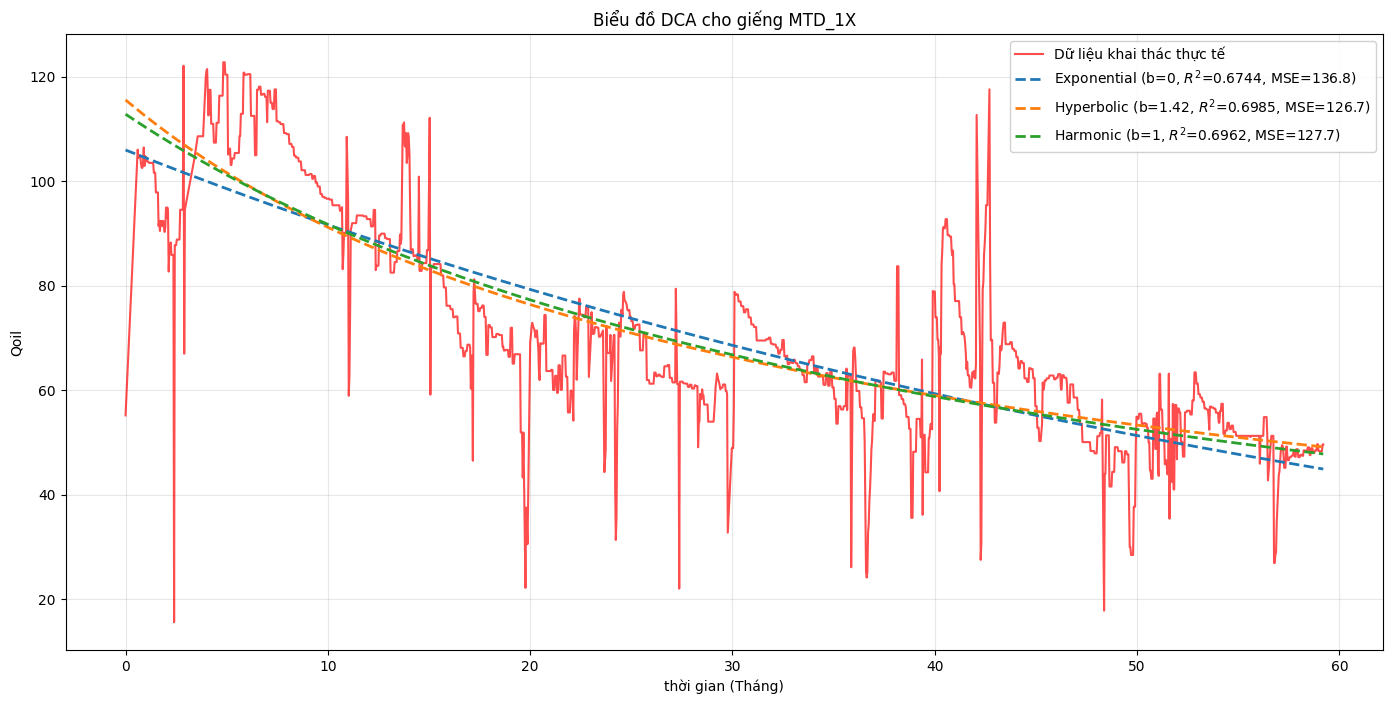

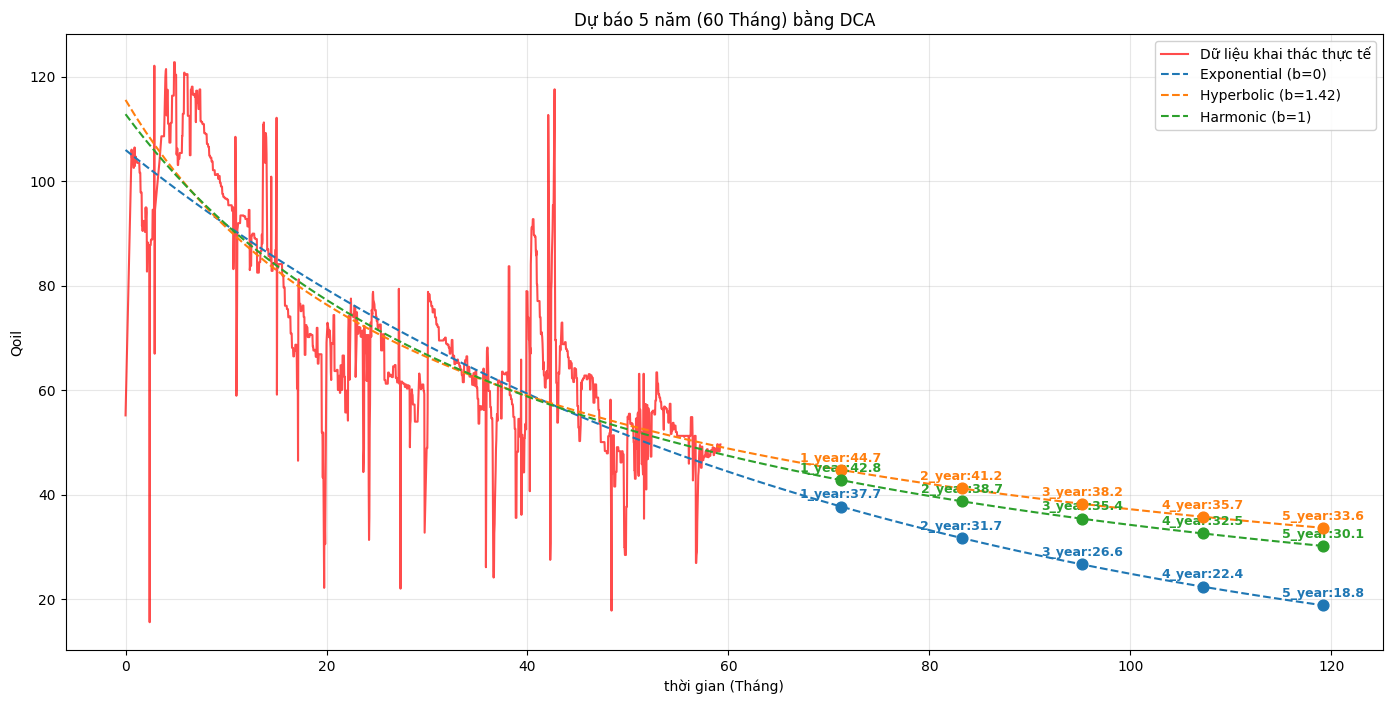

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------- CONFIG ----------
FILE_PATH = "/content/drive/MyDrive/Dữ liệu/BK_20_Test_3_clean.csv"
FUTURE_MONTHS = 60
POINT_MONTHS = [12, 24, 36, 48, 60]
USE_SMOOTHING = True
SAVGOL_WINDOW = 11
SAVGOL_POLY = 2
USE_OUTLIER_REMOVAL = True
IQR_MULTIPLIER = 1.5
MIN_POINTS_REQUIRED = 12
np.random.seed(42)
# ----------------------------

# ---------- DCA functions ----------
def exp_decline(t, qi, di):
    return qi * np.exp(-di * t)

def hyperbolic_decline(t, qi, di, b):
    return qi / ((1.0 + b * di * t) ** (1.0 / b))

def harmonic_decline(t, qi, di):
    return qi / (1.0 + di * t)

# ---------- Helpers ----------
def safe_savgol(x, window, poly):
    if len(x) < window:
        w = len(x) if len(x) % 2 == 1 else len(x)-1
        if w < 3:
            return x
        return savgol_filter(x, w, min(poly, w-1))
    return savgol_filter(x, window, poly)

def iqr_mask(series, multiplier=1.5):
    q1 = np.nanpercentile(series, 25)
    q3 = np.nanpercentile(series, 75)
    iqr = q3 - q1
    low = q1 - multiplier * iqr
    high = q3 + multiplier * iqr
    return (series >= low) & (series <= high)

# ---------- Load Data ----------
if not os.path.exists(FILE_PATH):
    raise FileNotFoundError(f"File not found: {FILE_PATH}\nIf using Colab mount drive: from google.colab import drive; drive.mount('/content/drive')")

df = pd.read_csv(FILE_PATH)

# ---------- Prepare time axis (months) ----------
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    df['t_days'] = (df['Date'] - df['Date'].iloc[0]).dt.days
    df['t_months'] = df['t_days'] / 30.0
    t_col = 't_months'
else:
    df = df.reset_index(drop=True)
    df['t_months'] = np.arange(len(df))
    t_col = 't_months'

if 'Qoil' not in df.columns:
    raise KeyError("Column 'Qoil' not found in dataset. DCA requires Qoil.")

df_q = df[[t_col, 'Qoil']].copy().dropna().reset_index(drop=True)
df_q.columns = ['t', 'Qoil']

if len(df_q) < MIN_POINTS_REQUIRED:
    raise ValueError(f"Time series too short for DCA (need >= {MIN_POINTS_REQUIRED}).")

# ---------- Outlier removal (mask) ----------
mask = np.ones(len(df_q), dtype=bool)
if USE_OUTLIER_REMOVAL:
    mask = iqr_mask(df_q['Qoil'].values, multiplier=IQR_MULTIPLIER)
    if mask.sum() < MIN_POINTS_REQUIRED:
        print("Warning: outlier removal removed too many points; skipping it.")
        mask = np.ones(len(df_q), dtype=bool)
    else:
        print(f"Outlier removal: kept {mask.sum()}/{len(mask)} points.")

t_all = df_q['t'].values
q_all = df_q['Qoil'].values

t_fit = t_all[mask]
q_fit = q_all[mask]

# ---------- Smoothing ----------
q_fit_processed = q_fit.copy()
if USE_SMOOTHING:
    window = min(SAVGOL_WINDOW, len(q_fit_processed))
    if window % 2 == 0:
        window -= 1
    if window >= 3:
        q_fit_processed = safe_savgol(q_fit_processed, window, SAVGOL_POLY)
        print(f"Applied Savitzky-Golay smoothing (window={window}, poly={SAVGOL_POLY}).")
    else:
        print("Savgol window too small; skipping smoothing.")

# ---------- Fit models ----------
results = {}

# Exponential
try:
    p0 = [q_fit_processed[0], 0.01]
    bounds = ([0, 1e-8], [np.max(q_fit_processed) * 5.0, 2.0])
    popt_exp, pcov_exp = curve_fit(exp_decline, t_fit, q_fit_processed, p0=p0, bounds=bounds, maxfev=10000)
    results['exp'] = {'params': popt_exp, 'pcov': pcov_exp}
except Exception as e:
    results['exp'] = {'error': str(e)}
    print("Exp fit error:", e)

# Hyperbolic
try:
    p0 = [q_fit_processed[0], 0.01, 0.5]
    bounds = ([0, 1e-8, 0.01], [np.max(q_fit_processed) * 5.0, 2.0, 5.0])
    popt_hyp, pcov_hyp = curve_fit(hyperbolic_decline, t_fit, q_fit_processed, p0=p0, bounds=bounds, maxfev=20000)
    results['hyperbolic'] = {'params': popt_hyp, 'pcov': pcov_hyp}
except Exception as e:
    results['hyperbolic'] = {'error': str(e)}
    print("Hyperbolic fit error:", e)

# Harmonic
try:
    p0 = [q_fit_processed[0], 0.01]
    bounds = ([0, 1e-8], [np.max(q_fit_processed) * 5.0, 2.0])
    popt_harm, pcov_harm = curve_fit(harmonic_decline, t_fit, q_fit_processed, p0=p0, bounds=bounds, maxfev=10000)
    results['harmonic'] = {'params': popt_harm, 'pcov': pcov_harm}
except Exception as e:
    results['harmonic'] = {'error': str(e)}
    print("Harmonic fit error:", e)

# ---------- Forecast horizon ----------
t_min = t_all.min()
t_max = t_all.max()
# Create monthly grid
n_points = int(np.round((t_max - t_min))) + FUTURE_MONTHS + 1
t_forecast = np.linspace(t_min, t_max + FUTURE_MONTHS, n_points)
forecast_df = pd.DataFrame({'t': t_forecast})

metrics = {}

for key, info in results.items():
    if 'error' in info:
        forecast_df[key + '_pred'] = np.nan
        metrics[key] = {'error': info['error']}
        continue

    if key == 'exp':
        qi, di = info['params']
        pred_in_sample = exp_decline(t_all, qi, di)
        pred_all = exp_decline(t_forecast, qi, di)
    elif key == 'hyperbolic':
        qi, di, b = info['params']
        pred_in_sample = hyperbolic_decline(t_all, qi, di, b)
        pred_all = hyperbolic_decline(t_forecast, qi, di, b)
    else:  # harmonic
        qi, di = info['params']
        pred_in_sample = harmonic_decline(t_all, qi, di)
        pred_all = harmonic_decline(t_forecast, qi, di)

    forecast_df[key + '_pred'] = pred_all

    rmse = np.sqrt(mean_squared_error(q_all, pred_in_sample))
    mae = mean_absolute_error(q_all, pred_in_sample)
    r2 = r2_score(q_all, pred_in_sample)
    metrics[key] = {'rmse': rmse, 'mae': mae, 'r2': r2, 'params': info['params']}

# ---------- Print metrics ----------
print("\n=== DCA FIT METRICS (in-sample) ===")
for key, val in metrics.items():
    if 'error' in val:
        print(f"{key}: ERROR - {val['error']}")
    else:
        print(f"{key.upper()} params: {val['params']}")
        print(f"  RMSE: {val['rmse']:.4f} | MAE: {val['mae']:.4f} | R2: {val['r2']:.4f}")
    print("-" * 40)

# ---------- Compute 5-year point values ----------
t_last = t_all.max()
year_points = [t_last + m for m in POINT_MONTHS]
print("\n=== Forecast values at +12, +24, +36, +48, +60 months (from last observed time) ===")

for key, info in results.items():
    if 'error' in info:
        continue
    if key == 'exp':
        qi, di = info['params']
        vals = exp_decline(np.array(year_points), qi, di)
    elif key == 'hyperbolic':
        qi, di, b = info['params']
        vals = hyperbolic_decline(np.array(year_points), qi, di, b)
    else:
        qi, di = info['params']
        vals = harmonic_decline(np.array(year_points), qi, di)

    print(f"\nModel: {key}")
    for m, v in zip(POINT_MONTHS, vals):
        print(f"  +{m} months -> Qoil = {v:.4f}")


# ---------- Plot 1: Observed vs fits (in-sample) WITH METRICS ----------
plt.figure(figsize=(17, 8))
plt.plot(t_all, q_all, label='Dữ liệu khai thác thực tế', color='red', linewidth=1.5, alpha=0.7)

for key in ['exp', 'hyperbolic', 'harmonic']:
    if 'params' in results.get(key, {}) and key in metrics:
        r2 = metrics[key]['r2']
        mse = metrics[key]['rmse'] ** 2

        if key == 'exp':
            qi, di = results[key]['params']
            pred_in = exp_decline(t_all, qi, di)
            label_str = f"Exponential (b=0, $R^2$={r2:.4f}, MSE={mse:.1f})"

        elif key == 'hyperbolic':
            qi, di, b = results[key]['params']
            pred_in = hyperbolic_decline(t_all, qi, di, b)
            label_str = f"Hyperbolic (b={b:.2f}, $R^2$={r2:.4f}, MSE={mse:.1f})"

        else: # harmonic
            qi, di = results[key]['params']
            pred_in = harmonic_decline(t_all, qi, di)
            label_str = f"Harmonic (b=1, $R^2$={r2:.4f}, MSE={mse:.1f})"

        plt.plot(t_all, pred_in, label=label_str,linestyle='--', linewidth=2)

plt.title("Biểu đồ DCA cho giếng MTD_1X")
plt.xlabel("thời gian (Tháng)")
plt.ylabel("Qoil")
plt.legend(loc='best', frameon=True, fancybox=True, framealpha=0.9)
plt.grid(alpha=0.3)
plt.show()

# ---------- Plot 2: Extended forecasts with Line Chart for Observed & Metrics Labels ----------
plt.figure(figsize=(17, 8))

# 1. Vẽ dữ liệu quan sát (Observed) dạng ĐƯỜNG
plt.plot(t_all, q_all, color='red', linewidth=1.5, alpha=0.7, label='Dữ liệu khai thác thực tế')

# 2. Vẽ các đường dự báo
for key in ['exp','hyperbolic','harmonic']:
    col = key + '_pred'
    if col in forecast_df and not forecast_df[col].isna().all() and key in metrics:
        r2 = metrics[key]['r2']
        mse = metrics[key]['rmse'] ** 2

        if key == 'exp':
            label_str = f"Exponential (b=0)"
        elif key == 'hyperbolic':
            b = results[key]['params'][2]
            label_str = f"Hyperbolic (b={b:.2f})"
        else:
            label_str = f"Harmonic (b=1)"

        plt.plot(forecast_df['t'], forecast_df[col], linestyle='--', label=label_str)

# 3. Đánh dấu và chú thích 5 điểm
colors = {'exp':'tab:blue','hyperbolic':'tab:orange','harmonic':'tab:green'}
for key in ['exp','hyperbolic','harmonic']:
    if 'params' not in results.get(key, {}):
        continue
    if key == 'exp':
        qi, di = results[key]['params']
        vals = exp_decline(np.array(year_points), qi, di)
    elif key == 'hyperbolic':
        qi, di, b = results[key]['params']
        vals = hyperbolic_decline(np.array(year_points), qi, di, b)
    else:
        qi, di = results[key]['params']
        vals = harmonic_decline(np.array(year_points), qi, di)

    plt.scatter(year_points, vals, marker='o', s=60, color=colors[key], edgecolor=colors[key], zorder=5)

    for m, t_abs, v in zip(POINT_MONTHS, year_points, vals):
        plt.annotate(f"{int(m/12)}_year:{v:.1f}", (t_abs, v),
                     textcoords="offset points", xytext=(0,6), ha='center', fontsize=9, color=colors[key], fontweight='bold')

plt.title(f"Dự báo 5 năm (60 Tháng) bằng DCA")
plt.xlabel("thời gian (Tháng)")
plt.ylabel("Qoil")
plt.legend(loc='best', frameon=True, fancybox=True, framealpha=0.9)
plt.grid(alpha=0.3)
plt.show()